In [14]:
import tomopy
import math
import dxchange
import os
import matplotlib.pyplot as plt
import numpy as np
from bm3d_streak_removal import full_streak_pipeline, extreme_streak_attenuation, multiscale_streak_removal
# import logging
# logging.basicConfig(level=logging.INFO)

In [2]:
def get_ind_list(name_list:list):
    ind = []
    ang_deg = []
    ang_rad = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        _ang = _split[-3] + '.' + _split[-2]
        index = int(_index)
        angle = float(_ang)
        ind.append(index)
        ang_deg.append(angle)
        ang_rad.append(math.radians(angle))
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), (sorted(ang_deg)), np.array(sorted(ang_rad)), ind

def get_list(name_list:list):
    ind = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        index = int(_index)
        ind.append(index)
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), ind

def _init_arr_from_stack(fname, number_of_files, slc=None):
    """
    Initialize numpy array from files in a folder.
    """
    _arr = dxchange.read_tiff(fname, slc)
    size = (number_of_files, _arr.shape[0], _arr.shape[1])
    return np.empty(size, dtype=_arr.dtype)

def read_tiff_stack(fdir, fname:list):
    arr = _init_arr_from_stack(os.path.join(fdir, fname[0]), len(fname))
    for m, name in enumerate(fname):
        arr[m] = dxchange.read_tiff(os.path.join(fdir, name))
    return arr

def find_proj180_ind(ang_list:list):
    dif = [abs(x-180) for x in ang_list]
    difmin = min(dif)
    ind180 = dif.index(difmin)
    return (ind180, ang_list[ind180])

def shrink_window(corners, size):
    corners[0][0] = corners[0][0] + size
    corners[0][1] = corners[0][1] + size
    corners[1][0] = corners[1][0] + size
    corners[1][1] = corners[1][1] - size
    corners[2][0] = corners[2][0] - size
    corners[2][1] = corners[2][1] - size
    corners[3][0] = corners[3][0] - size
    corners[3][1] = corners[3][1] + size
    return corners

def set_roi(corners, xmin, ymin, xmax, ymax):
    corners[0][0] = xmin
    corners[0][1] = ymin
    corners[1][0] = xmin
    corners[1][1] = ymax
    corners[2][0] = xmax
    corners[2][1] = ymax
    corners[3][0] = xmax
    corners[3][1] = ymin
    return corners

In [3]:
###################### need to change start
ipts="23788"
###################### need to change end

In [4]:
ct_scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_scan_loc)

['2021_08_17_HEA',
 'Nov16_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 '2021_08_14_plastic_2nd_resume',
 'June29_2020',
 'Aug19_2020',
 '2021_08_14_plastic_2nd',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'Feb10_2020']

Found index of 180 degree projections:  643
Loading CT projections...
(1290, 2048, 2048)


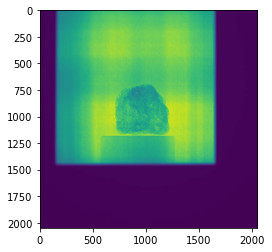

In [5]:
###################### need to change start
ct_scan_dir = os.path.join(ct_scan_loc, "Aug24_2020")
###################### need to change end
# os.listdir(ct_scan_dir)
ct_name, ang_deg, theta, ind_list = get_ind_list(os.listdir(ct_scan_dir))
proj180_ind = find_proj180_ind(ang_deg)[0]
print('Found index of 180 degree projections: ', proj180_ind)
print('Loading CT projections...')
proj = read_tiff_stack(fdir=ct_scan_dir, fname=ct_name)
print(proj.shape)
plt.imshow(proj[0])
plt.show()

# Open Beam (OB)

In [6]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2021_08_19_shale',
 'Nov15_2019',
 'Dec19_2019',
 '2021_08_17_HEA',
 'Dec18_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 '2021_03_25',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_02_coin_cell_Maha',
 '2021_08_14_zyla_1x_OB_11mm',
 '2021_08_14_zyla_1x_OB_16mm',
 'Aug19_2020',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'June27_2020',
 '2021_03_25_plastic',
 'Feb10_2020']

Loading Open Beam (OB)...
(10, 2048, 2048)


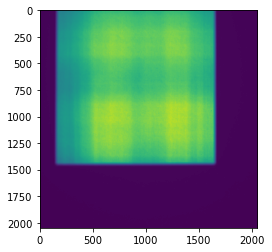

In [7]:
###################### need to change start
ob_dir = os.path.join(ob_loc, "Aug24_2020")
###################### need to change end
# os.listdir(ob_dir)
ob_name, ob_ind_list = get_list(os.listdir(ob_dir))
print("Loading Open Beam (OB)...")
ob = read_tiff_stack(fdir=ob_dir, fname=ob_name)
print(ob.shape)
plt.imshow(ob[0])
plt.show()

# Dark Current (DC)

In [8]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2021_08_19_shale',
 'Aug21_2020',
 'Dec19_2019',
 '2021_05_10_shutter_open',
 'Feb06_2020',
 'Oct29_2019',
 '2021_08_16_DF_high_res',
 '2021_08_19_zyla',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_05',
 'Aug25_2020',
 '2021_08_27_DF_30s',
 'Nov12_2019',
 'July01_2020',
 'June27_2020',
 'July02_2020',
 'Feb11_2020',
 'Nov18_2019']

Loading Dark Current (DC)...
(10, 2048, 2048)


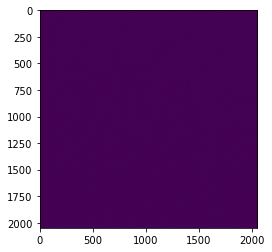

In [9]:
###################### need to change start
dc_dir = os.path.join(dc_loc, "Aug24_2020")
###################### need to change end
# os.listdir(dc_dir)
dc_name, dc_ind_list = get_list(os.listdir(dc_dir))
print("Loading Dark Current (DC)...")
dc = read_tiff_stack(fdir=dc_dir, fname=dc_name)
print(dc.shape)
plt.imshow(dc[0])
plt.show()

# Cropping the slits

[[ 136    0]
 [ 136 1466]
 [1658 1466]
 [1658    0]]


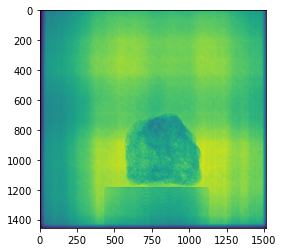

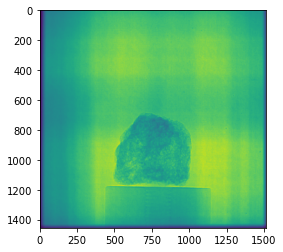

In [10]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
print(slit_box_corners)
proj = tomopy.prep.alignment.remove_slits_aps_1id(proj, slit_box_corners)
ob = tomopy.prep.alignment.remove_slits_aps_1id(ob, slit_box_corners)
dc = tomopy.prep.alignment.remove_slits_aps_1id(dc, slit_box_corners)
plt.imshow(proj[0])
plt.show()
plt.imshow(proj[proj180_ind])
plt.show()

# Define the ROI

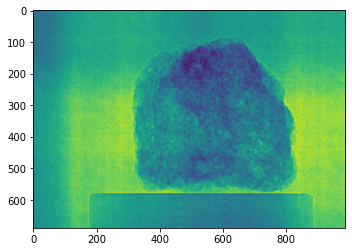

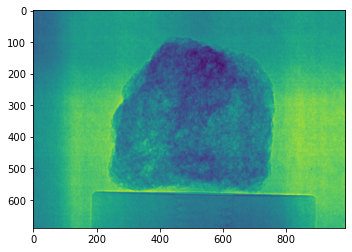

In [11]:
roi_corners = set_roi(corners=slit_box_corners, xmin=250, ymin=600, xmax=1250, ymax=1300)
proj = tomopy.prep.alignment.remove_slits_aps_1id(proj, roi_corners)
ob = tomopy.prep.alignment.remove_slits_aps_1id(ob, roi_corners)
dc = tomopy.prep.alignment.remove_slits_aps_1id(dc, roi_corners)
plt.imshow(proj[0])
plt.show()
plt.imshow(proj[proj180_ind])
plt.show()

# Remove Outliers

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

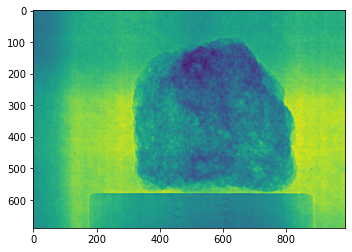

In [12]:
proj_c = tomopy.misc.corr.remove_outlier(proj, 50)
plt.imshow(proj_c[0])
plt.show()

# Normalization

In [15]:
proj = tomopy.normalize(proj_c, ob, dc)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

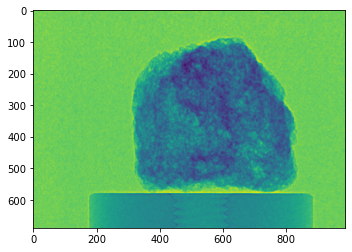

In [16]:
plt.imshow(proj[0])
plt.show()

# Beam fluctuation correction

In [17]:
proj_n = tomopy.prep.normalize.normalize_bg(proj, air=50)

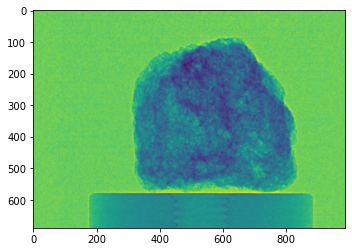

In [18]:
plt.imshow(proj_n[0])
plt.show()

# Minus log conversion

In [19]:
proj_m = tomopy.minus_log(proj_n)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

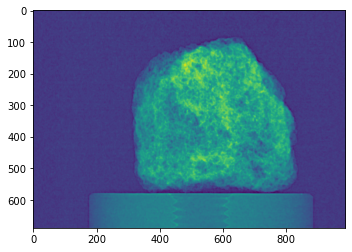

In [20]:
plt.imshow(proj_m[0])
plt.show()

# Find Center of Rotation

In [21]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_m[0,:,:]), np.squeeze(proj_m[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation', rot_center)

Estimated center of rotation 537.5


# Ring Artifact Removal

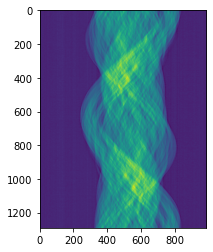

In [22]:
plt.imshow(proj_m[:, 500, :])
plt.show()

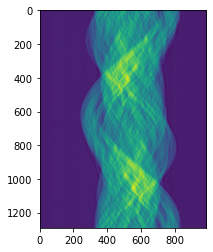

In [23]:
proj_rmv = tomopy.prep.stripe.remove_all_stripe(proj_m)
plt.imshow(proj_rmv[:, 500, :])
plt.show()

In [24]:
proj_bm3d_norm = extreme_streak_attenuation(proj_m)

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2


In [26]:
proj_bm3d_denoised = multiscale_streak_removal(proj_bm3d_norm)

Denoising sinogram 0
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 15
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 16
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 17
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 18
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 19
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 20
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 21
k

Denoising sinogram 173
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 174
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 175
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 176
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 177
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 178
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 179
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 180
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 181
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 182
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 183
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 184
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 185
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 186
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 187
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 188
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 189
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 190
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 191
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 192
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 193
k: 4
k: 3
k: 2
k:

k: 2
k: 1
k: 0
Denoising sinogram 344
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 345
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 346
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 347
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 348
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 349
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 350
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 351
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 352
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 353
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 354
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 355
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 358
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 359
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 360
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 361
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 362
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 363
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 364
k:

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 515
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 516
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 517
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 518
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 519
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 520
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 521
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 522
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 523
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 529
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 530
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 531
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 532
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 533
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 534
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 686
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 687
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 688
k: 4
k: 3
k: 2
k: 1
k: 0


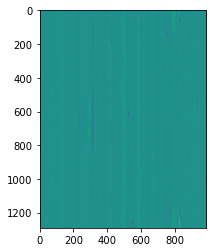

In [29]:
plt.imshow(proj_m[:, 500, :] - proj_rmv[:, 500, :])
plt.show()

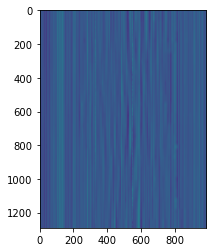

In [28]:
plt.imshow(proj_m[:, 500, :] - proj_bm3d_denoised[:, 500, :])
plt.show()

# Reconstruction

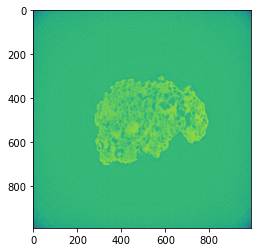

In [30]:
recon = tomopy.recon(proj_m, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
plt.imshow(recon[500, :, :])
plt.show()

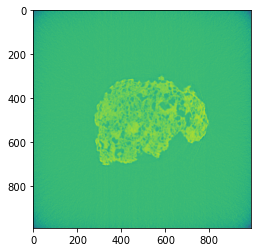

In [31]:
recon_rmv = tomopy.recon(proj_rmv, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
plt.imshow(recon_rmv[500, :, :])
plt.show()

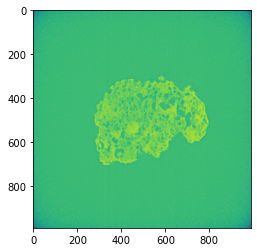

In [32]:
recon_bm3d = tomopy.recon(proj_bm3d_denoised, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
plt.imshow(recon_bm3d[500, :, :])
plt.show()

# Export recon files

In [ ]:
################ change save path for your own
fname = '/netdisk/imaging/data_hfir/for_shimin/DOE_Mod/recons/rec02_crop/rec' 
dxchange.write_tiff_stack(recon, fname=fname, overwrite=False)